[Link to this document's Jupyter Notebook](./0415-PROJECT_Part2.ipynb)

# Part 2 - Speeding up rendering in Blender using parallel method

By "Samuel Chen"

 
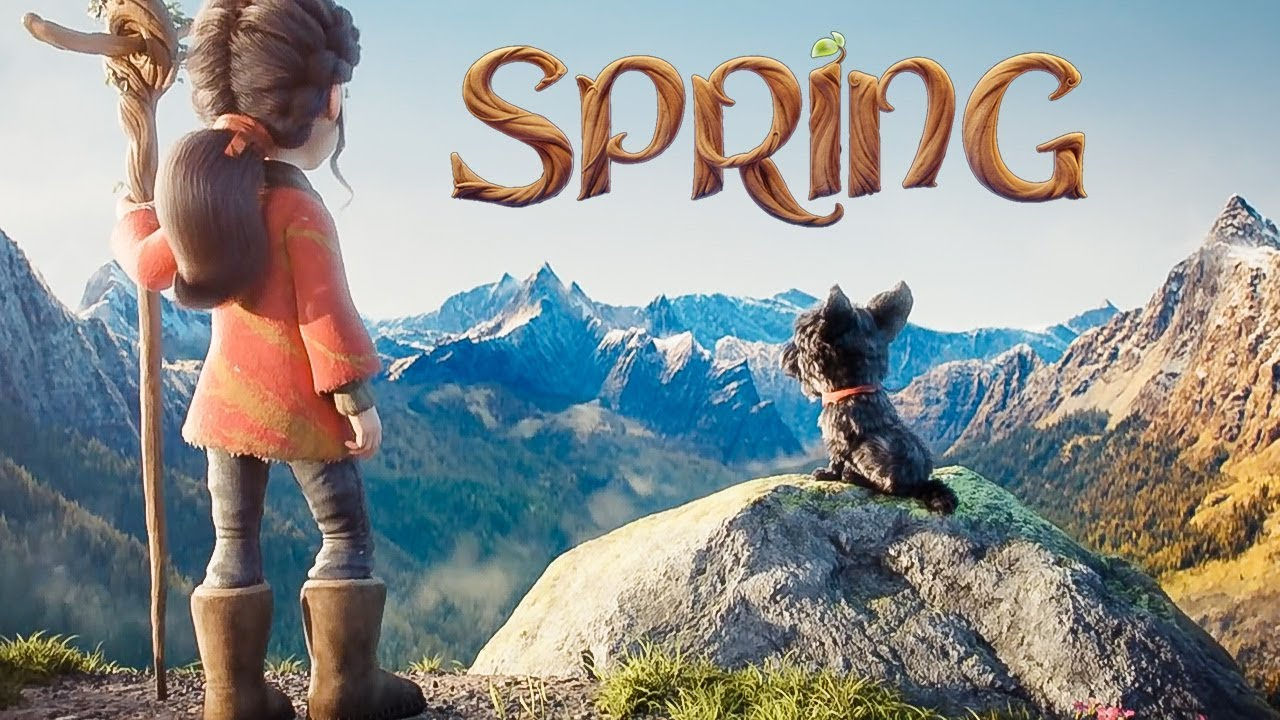

Image from: https://www.iamag.co/making-of-blender-open-movie-spring/

---
# Abstract
The domain that will be covered in this project is image/video rendering in blender.  

Blender is the free and open source 3D creation suite. It supports the entirety of the 3D pipeline—modeling, rigging, animation, simulation, rendering, compositing and motion tracking, even video editing and game creation.  

The process of rendering is basically turning a 3D scenes, whether single frame for a static picture or many frames for a video in 2D pictures. 

"What the render looks like is defined by cameras, lights and materials. These are shared between Eevee and Cycles, however some features are only supported in one or the other."
        --From https://docs.blender.org/manual/en/latest/render/introduction.html



---
# Methodology


For this project, we will use Pleasantly Parallel method to make a "Blender farm" on HPCC by subbmit the job to Slurm as a job array.

The project is done on DevNode `dev-amd20-v100`

## Loads

First of all, we need to some imports/loads on HPCC to make sure everything works:

```
ml icc/2017.1.132-GCC-6.3.0-2.27  impi/2017.1.132
ml ifort/2017.1.132-GCC-6.3.0-2.27  impi/2017.1.132
module load Python/3.6.1
module load Blender
```
## Install
If Blender is not installed on HPCC, then we need to install it ourselves.  
Do the following:

- Go to Blender website and download the file, https://www.blender.org/download/
- Then unzip the tar file (name may varie depends on the version) and run blender(May need to load certain module)
- Use the following commands
```
tar -xvzf blender-2.91.2-linux64.tar
cd blender-2.91.2-linux64
blender
```
Done.  


## Serial + Example
Now, after we have our Blender working, we will be runing a serial render to test:  
In this folder, we have an example file from Blender website, file name `fishy_cat.blend`  
Simply run the following commmand:
```
blender -b fishy_cat.blend -f 0 -F PNG 
```
`-b` : Run in background  
`-f 0`: Render the 0th frame  
`-F PNG`: Set the render format.  

The bash file `bash too_lazy_example.sb` contains all the commands above.  

Now we should be able to see a folder `fishy_cat` which contains the result PNG file.

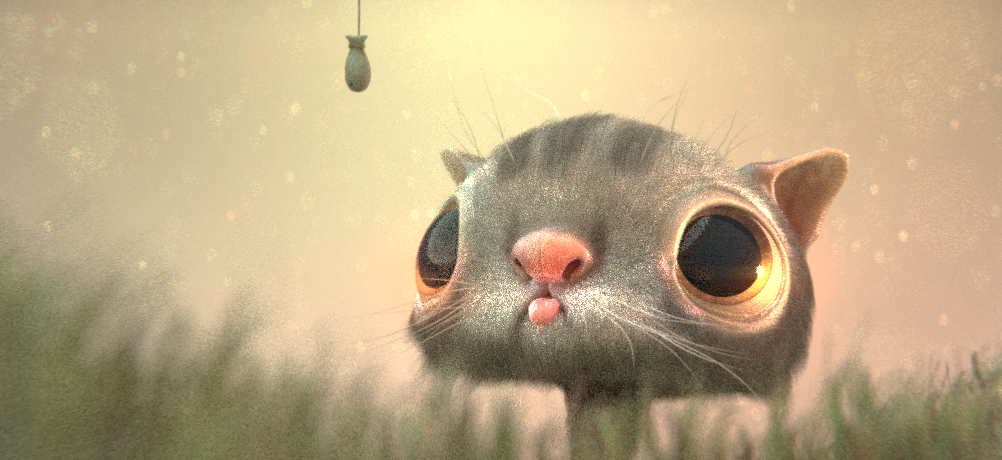

---
# Timing Results for single frame



For timing study, I made a .sh file called `time_one_F.sh`, which run both `cat_example_cycles_CPU.sh`  `cat_example_cycles_GPU.sh` 3 times. 
To run the file, just simply use 
```
bash time_one_F.sh
```
`-t `: using number of  threads  
`-E `: Choose render Engine  
`-- --cycles-device `: Choose using GPU or CPU  

#### Note:

While I was running the code on HPCC, the timing result changed a lot through the differtent testing despite I am using the same code.

Usually, the one frame render for the cat file should just take about around 30 seconds.  
When I ran the script, the avgerage time increased to over double the time it needed to render, the cause is unkown.

In [8]:
import matplotlib.pyplot as plt

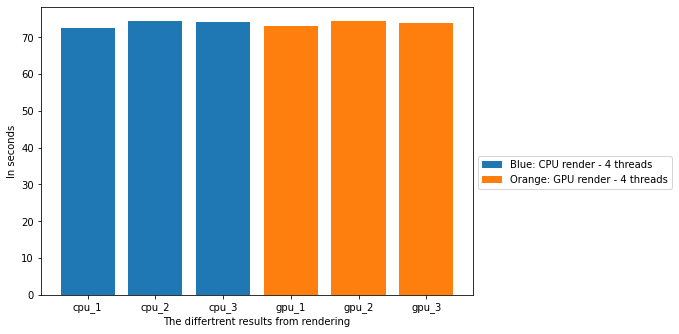

In [24]:
one_frame_CPU = [60+12.39,60+14.30,60+14.02]

one_frame_GPU = [60+12.95,60+14.52,60+13.93]

all_try = one_frame_CPU + one_frame_GPU


name_cpu = ["cpu_1","cpu_2","cpu_3"]
name_gpu = ["gpu_1","gpu_2","gpu_3"]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.bar(name_cpu,one_frame_CPU)
plt.bar(name_gpu,one_frame_GPU)
plt.ylabel("In seconds")
plt.xlabel("The differtrent results from rendering")
plt.legend(("Blue: CPU render - 4 threads", "Orange: GPU render - 4 threads"),bbox_to_anchor=(1, 0.5),
           loc='upper left')

Now, using 12 threads:


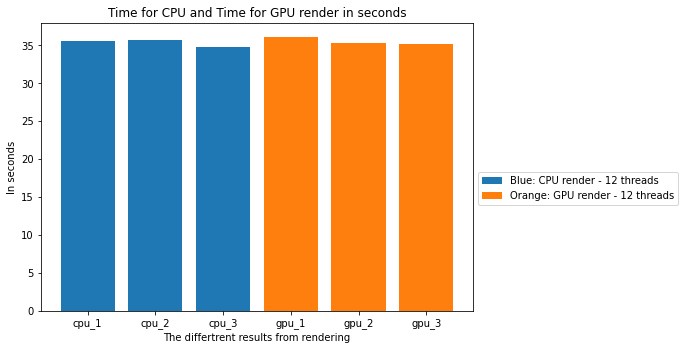

In [79]:
one_frame_CPU_2 = [35.58,35.67,34.73]

one_frame_GPU_2 = [36.14,35.35,35.15]



fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.bar(name_cpu,one_frame_CPU_2)
plt.bar(name_gpu,one_frame_GPU_2)
plt.ylabel("In seconds")
plt.xlabel("The differtrent results from rendering")
plt.legend(("Blue: CPU render - 12 threads", "Orange: GPU render - 12 threads"),bbox_to_anchor=(1, 0.5),
           loc='upper left')
plt.title("Time for CPU and Time for GPU render in seconds")
plt.show()

#### Discussion and Future Work:

From the result we got so far, we can say it would seems that the thread `-t ` argument helped speeding up the rendering, but we cannot confirm that yet.   

Becuase this result is what I got before when I run test script with different thread number.  

Let's change the threads number to 48!

<Figure size 432x288 with 0 Axes>

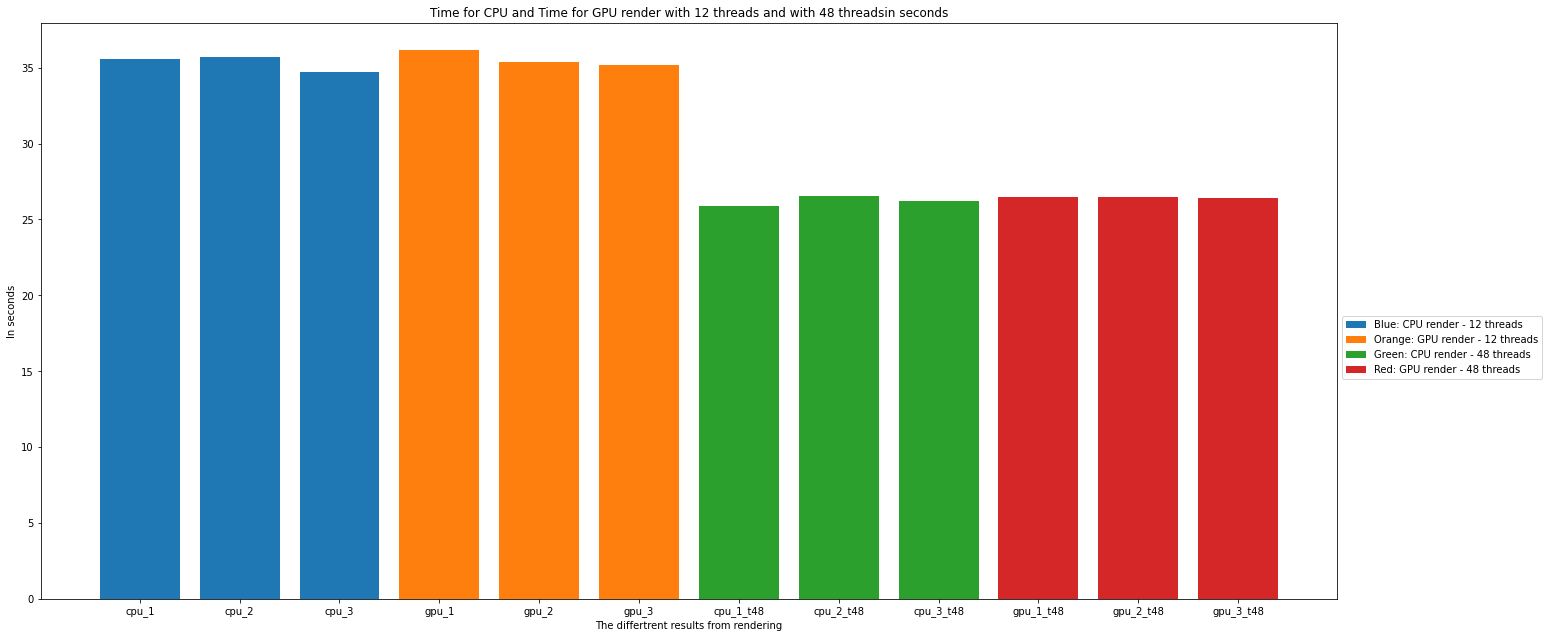

In [80]:
one_frame_CPU_3 = [25.89,26.56,26.21]

one_frame_GPU_3 = [26.46,26.46,26.40]



name_cpu_t48 = ["cpu_1_t48","cpu_2_t48","cpu_3_t48"]
name_gpu_t48 = ["gpu_1_t48","gpu_2_t48","gpu_3_t48"]

fig = plt.figure()
fig= plt.figure(figsize=(18,8))
ax = fig.add_axes([0,0,1,1])
plt.bar(name_cpu,one_frame_CPU_2)
plt.bar(name_gpu,one_frame_GPU_2)
plt.bar(name_cpu_t48,one_frame_CPU_3)
plt.bar(name_gpu_t48,one_frame_GPU_3)
plt.ylabel("In seconds")
plt.xlabel("The differtrent results from rendering")
plt.legend(("Blue: CPU render - 12 threads", "Orange: GPU render - 12 threads","Green: CPU render - 48 threads",
            "Red: GPU render - 48 threads"),bbox_to_anchor=(1, 0.5),
           loc='upper left')
plt.title("Time for CPU and Time for GPU render with 12 threads and with 48 threadsin seconds")
plt.show()

#### Discussion and Future Work:

Now we can make sure increase threads number does speed up the rendering processes，since there's abot 10 seconds improvement on the timing when we use 48 number of threads.

However, I do not think I use the device argument correctly, since the CPU and GPU rendering time are extremly similar to each other under the same condition.

There is also option that we can enable CUDA while using GPU rendering, since I failed to determine if my GPU is doing the work for rending, I cannot do that yet, but onece I figured it out, I can try it.

### Video rendering

Now we have rendered a single frame, let's test it with an animation.

We will be using the Blender demo `spring.blend`

Since git lab has file size limitation as 100Mb, we will have to download from:

https://cloud.blender.org/p/gallery/5d2607ee6b3001d49bab798a


Since thie blend file is made from Blender/2.8, we will be changing the modules a little bit:  

```
ml icc/2019.1.144-GCC-8.2.0-2.31.1  impi/2018.4.274
ml ifort/2019.1.144-GCC-8.2.0-2.31.1  impi/2018.4.274
ml GCCcore/8.2.0
module load Python/3.7.2
module load Blender/2.80-Python-3.7.2
module load CUDA

```

#### Note:

For some reasons, the flag for bender `-s`&`-e` will cause blender to quit before it can start the rendering (which it should not be),

I wrote a script to run the serial code witg `-a`, which means to render all the frames, and yes, we have to use `ctrl`+`c` to force kill 
the process when we want, (The Node woll also kill the job for you since it reqires a lot memories, it was around frame 7, when it got kill for me on the Node).

Run the command to obtain serial rendering speed/time, quit whenever we have enough data.

``` 
bash spring_serial.sh
```
Run the command to obtain rendering speed/time using 48 threads, quit whenever we have enough data.
``` 
bash spring_threads.sh
```

I chose to use those two scripts to render the first 5 frames of this blend file. 

#### Note!!!:
From this step, something went wrong with the git directory so I started using the back up git file. 
The code might be slightly different than what they used to be, but it should be not effecting the result, since I already raned the code many times and obtained the result. 

Text(0.5, 1.0, 'Time for serial and Time for multi threads render in seconds')

<Figure size 432x288 with 0 Axes>

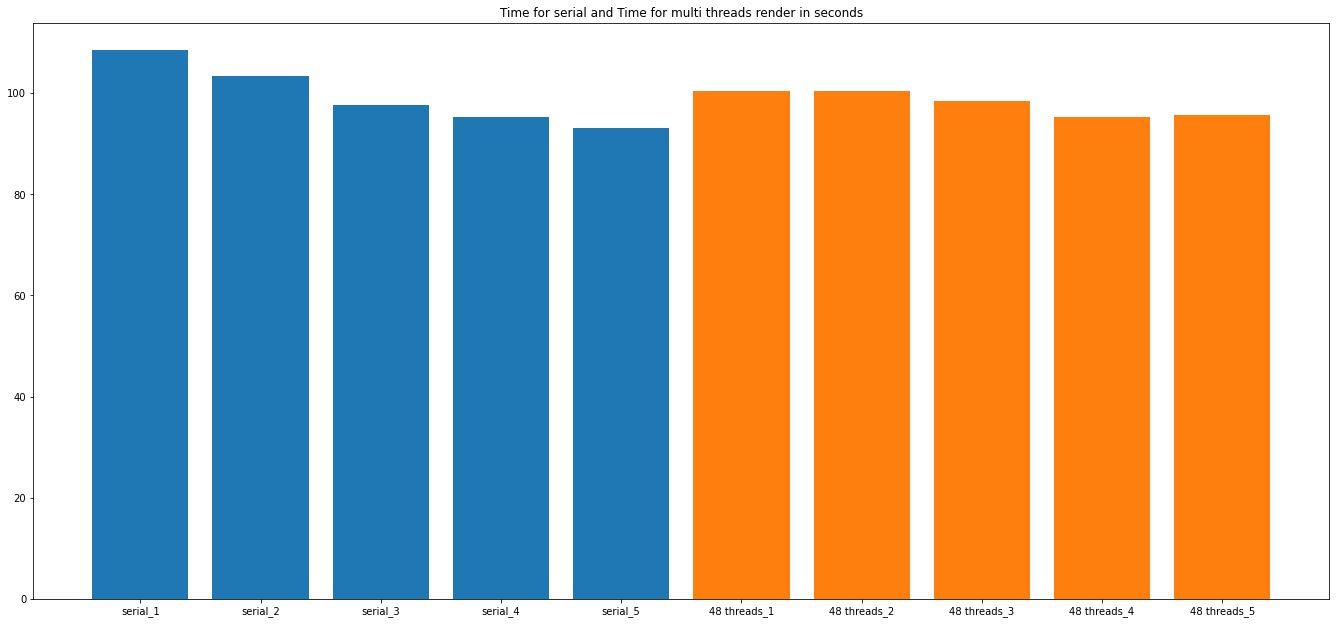

In [81]:
times_serial = [60+48.46,60+43.42,60+37.62,60+35.23,60+33.04]
name_s = ["serial_1","serial_2","serial_3","serial_4","serial_5"]

times_48threads = [60+40.36,60+40.48,60+38.50,60+35.19,60+35.69]
name_t = ["48 threads_1","48 threads_2","48 threads_3","48 threads_4","48 threads_5"]

fig = plt.figure()
fig= plt.figure(figsize=(18,8))
ax = fig.add_axes([0,0,1,1])
plt.bar(name_s,times_serial)
plt.bar(name_t,times_48threads)
plt.title("Time for serial and Time for multi threads render in seconds")

As we can see, the serial and the 48 threads timing result are really similar, why is that?  
What if we force Blender to render it with only 1 thread?

In the `spring_serial.sh` we added `-t 1` at the end of the command line to force it to render with only one thread.

After a long wait, I got the result:

Text(0.5, 1.0, 'Time for serial, multi threads, single thread render in seconds')

<Figure size 432x288 with 0 Axes>

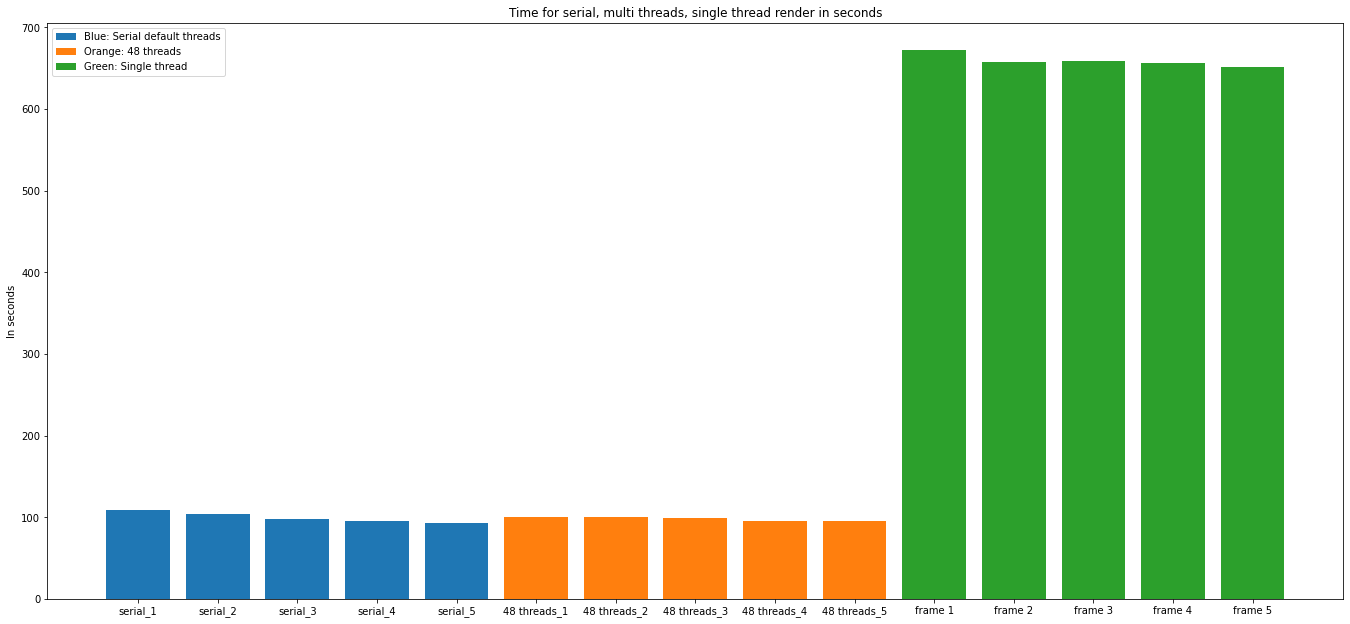

In [82]:
times_one = [60*11+11.76,60*10+57.32,60*10+59.26,60*10+56.59,60*10+51.75]
name_1 = ["frame 1","frame 2","frame 3","frame 4","frame 5"]
fig = plt.figure()
fig= plt.figure(figsize=(18,8))
ax = fig.add_axes([0,0,1,1])
plt.bar(name_s,times_serial)
plt.bar(name_t,times_48threads)
plt.bar(name_1,times_one)
plt.ylabel("In seconds")
plt.legend(("Blue: Serial default threads", "Orange: 48 threads","Green: Single thread"),loc='upper left')

plt.title("Time for serial, multi threads, single thread render in seconds")

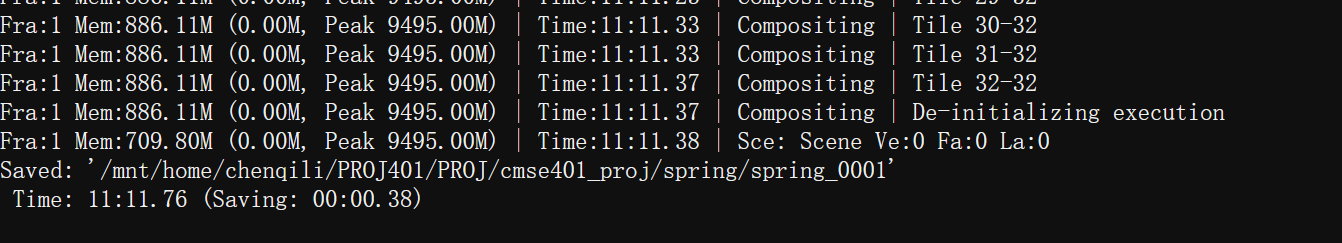

#### Discussion and Future Work:


With only one thread, the time that took to render one frame in `spring.blend` is almost 7 times longer than the serial code.

The result answered my question above, what I think is: when we are not using any arguements/flags, Blender used some sort of default value to asgin the thread number, so when we run the serial and thr multi threads scripts, we obtain the similar results. 

### Run the rendering in a job array

Run the command to subbmit job to slurm:
```
sbatch spring_array.sb
```
This code will render the first 10 frames in the file.


Text(0.5, 1.0, 'Time for serial, multi threads, single thread and job array render in seconds')

<Figure size 432x288 with 0 Axes>

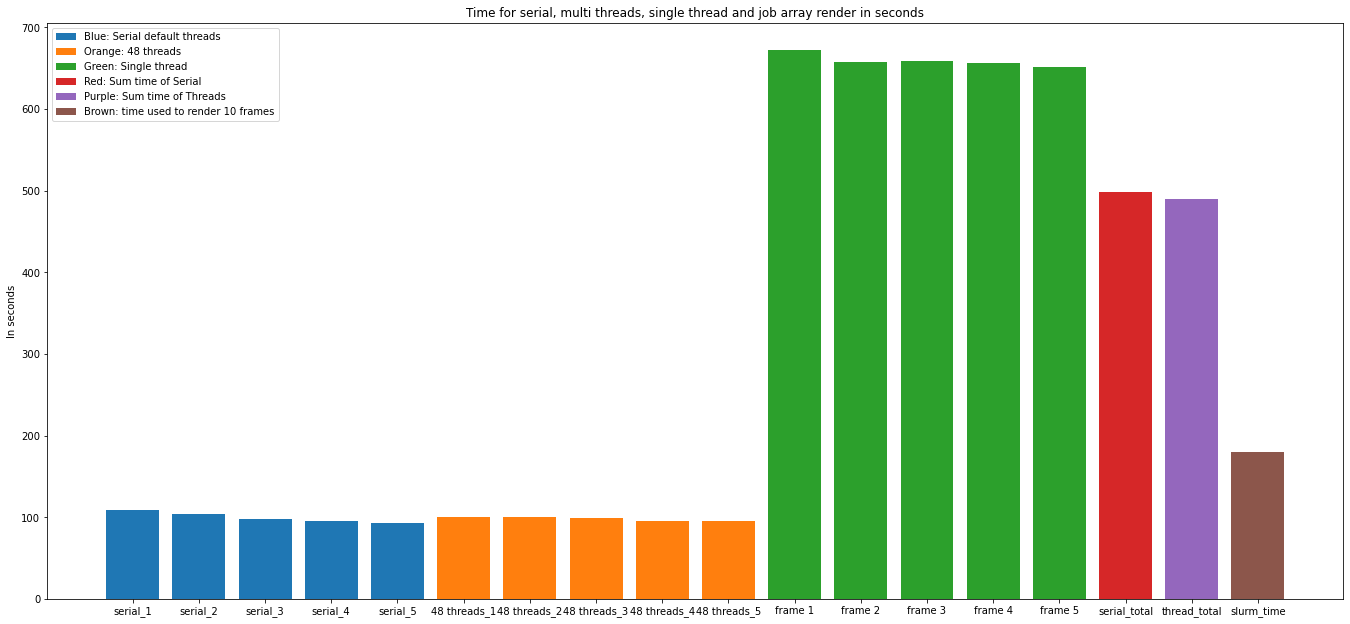

In [83]:
times_serial = [60+48.46,60+43.42,60+37.62,60+35.23,60+33.04]
name_s = ["serial_1","serial_2","serial_3","serial_4","serial_5"]

times_48threads = [60+40.36,60+40.48,60+38.50,60+35.19,60+35.69]
name_t = ["48 threads_1","48 threads_2","48 threads_3","48 threads_4","48 threads_5"]

serial_sum = [sum(times_serial)]
name_serial_sum = ["serial_total"]
thread_sum = sum(times_48threads)
name_thread_sum = ["thread_total"]
slurm_time = [2*60+59.63]
name_slurm = ["slurm_time"]

fig = plt.figure()
fig= plt.figure(figsize=(18,8))
ax = fig.add_axes([0,0,1,1])

plt.bar(name_s,times_serial)
plt.bar(name_t,times_48threads)
plt.bar(name_1,times_one)

plt.bar(name_serial_sum,serial_sum)
plt.bar(name_thread_sum ,thread_sum )

plt.bar(name_slurm,slurm_time)

plt.ylabel("In seconds")
plt.legend(("Blue: Serial default threads", "Orange: 48 threads",
            "Green: Single thread","Red: Sum time of Serial",
           "Purple: Sum time of Threads","Brown: time used to render 10 frames"),loc='upper left')
plt.title("Time for serial, multi threads, single thread and job array render in seconds")

The total time used to render 10 frames using job array is almost half of the total time for running with optimization `-t 48` to render 5 frames.

---
# Concluding Discussion and Future Work


This project is meant to find a method to speeding up the rendering speed in Blender on HPCC.  
From the result so far, I will say that The Pleasantly Parallel job using Job Arrays method works on Blender redering, and it worked quite well.

There are more method to speed up Blender rendering, such as enable using CUDA in GPU, but I haven't figure out how to do that yet.

##### There are some intresting stuff I learned and I noticed while I am doing the project :



```
#!/bin/bash
#SBATCH --time=03:59:00
#SBATCH --mem=120GB
#SBATCH -N 1
#SBATCH -c 12
#SBATCH --gres=gpu:1
#SBATCH --array=1-10
```
This is the config for `spring_array.sb `

```
#!/bin/bash

#SBATCH --time=03:59:00
#SBATCH --mem=100GB
#SBATCH -N 1
#SBATCH -c 12
#SBATCH --gres=gpu:1
#SBATCH --array=1-50
```
This is config for `spring_array_100.sb `

```

#!/bin/bash
#SBATCH --time=03:59:00
#SBATCH --mem=120GB
#SBATCH -N 1
#SBATCH -c 24
#SBATCH --gres=gpu:1
#SBATCH --array=1-500
```
This is config for `test_array.sb `

Although they are not very different from each other, the time it reqired to render a single frame has huge differences.


Fra:1 Mem:900.27M (0.00M, Peak 9696.85M) | Time:02:44.46 | Compositing | De-initializing execution  
Fra:1 Mem:723.96M (0.00M, Peak 9696.85M) | Time:02:44.47 | Sce: Scene Ve:0 Fa:0 La:0  
Saved: '/mnt/home/chenqili/PROJ401/PROJ/cmse401_proj/spring/array__0001'  
 Time: 02:44.73 (Saving: 00:00.26)  
 The above is the time to render one frame in `spring_array.sb `
 
=====================  
 
Fra:1 Mem:8497.94M (0.00M, Peak 8498.68M) | Time:16:39.72 | Remaining:38:55.66 | Mem:5638.42M, Peak:5639.14M | Scene, View Layer |   Rendered 2102/7938 Tiles, Denoised 1954 tiles  
Fra:1 Mem:8497.91M (0.00M, Peak 8498.68M) | Time:16:39.88 | Remaining:38:55.00 | Mem:5638.38M, Peak:5639.14M | Scene, View Layer |   Rendered 2102/7938 Tiles, Denoised 1955 tiles  
[chenqili@dev-amd20-v100 cmse401_proj]$   
The above output is from `spring_array_100.sb `, it did not finish rendering wihle I am writing the report, but the estimated time is about 55 mins.

=====================  
 
 Fra:6 Mem:9696.58M (0.00M, Peak 9696.81M) | Time:02:04.96 | Remaining:00:11.68 | Mem:6554.88M, Peak:6555.10M | Scene, View Layer |   Rendered 4308/7938 Tiles, Denoised 4144 tiles  
Fra:6 Mem:9696.61M (0.00M, Peak 9696.81M) | Time:02:04.96 | Remaining:00:11.68 | Mem:6554.91M, Peak:6555.10M | Scene, View Layer |   Rendered 4309/7938 Tiles, Denoised 4144 tiles  
The above is from `test_array.sb `, which renders 500 frames, but it would seems each frame only too about 13 mins.
 
=====================  
what caused this huge time increases still remain unknown to me.

While I was doing thje project, I also learned a lot about how slurm job array works:

This is one of my screenshot got by using command `squeue -u chenqili`:
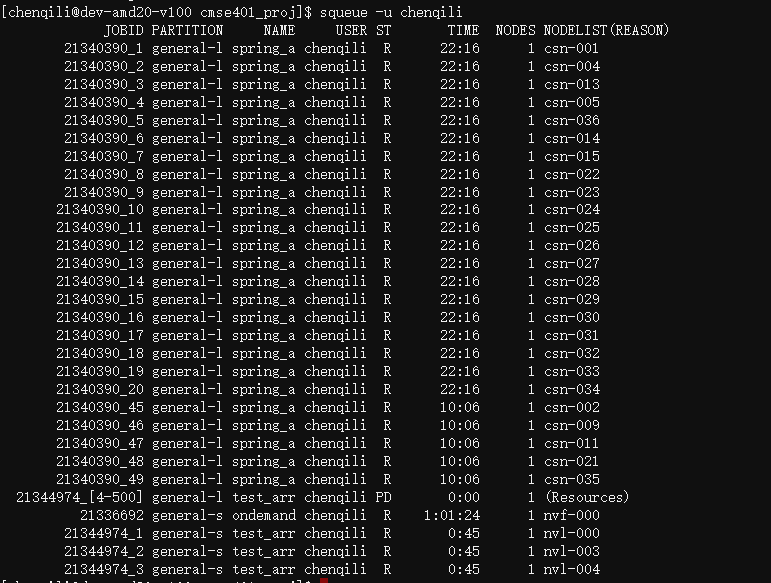

Different jobs are managed to different nodes, those jobs which subbmited to Slurm has go thourgh finding Resources Phase, and find waitting in the queue untill it it the job's turn.
And since this is Pleasantly Parallel job, the outcome does not depends on each other, so the order does not matter.

Future Work:  
It would seem that I will not be able to render the whole movie in a day and merge the png files into an AVI or MP4 files, but I would like to try it in the futrue, such as "Speeding up merging using parallel computing method"

---
# References


* Example: https://www.blender.org/download/demo-files/
* Blender: https://www.blender.org/download/
* Blender Manual: https://docs.blender.org/manual/en/latest/
* Bash Code: HPCC getexample

-----
### Congratulations, you are done!

Now, you just need to create a second directory in your git repository and include your report as an md or ipynb file in the directory along with any additional figures and files needed to reproduce the results.  You instructor should already have your git repository and be able to pull in your changes. 

Written by Dr. Dirk Colbry, Michigan State University
<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

----